In [39]:
import pandas as pd
pd.reset_option("all")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = 2000
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/pandas/_config/config.py:620: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/pandas/_config/config.py:620: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [88]:
df = pd.read_csv('fotmob_odds_form_df.csv', index_col = [0])

In [89]:
col_names = df.columns

In [90]:
threshold = 5
df_dropped = df.dropna(thresh=df.shape[1] - threshold + 1)
df = df.fillna(0)

In [91]:
qual_df = df.select_dtypes(include='object')

df = df.select_dtypes(include=['int', 'float'])

In [92]:
# non-penalty xg

df['np_xg_diff'] = df['expected_goals_(xg)_diff'] - df['xg_penalty_diff']
# efficiency metrics
df['efficiency_metric_diff'] = df['np_xg_diff'] / df['total_shots_diff']
# aggression factor
df['aggression_factor_diff'] = df['fouls_committed_diff'] + df['yellow_cards_diff'] + df['red_cards_diff']
# offensive/defensive balance
df['off_def_balance_diff'] = df['tackles_won_diff'] - df['successful_dribbles_diff']
# overall form difference
df['overall_form_diff'] = df['home_form_points_gained'] - df['away_form_points_gained']
# form efficiency
df['home_form_efficiency'] = df['home_form_goals_scored'] / df['home_form_goals_conceded']
df['away_form_efficiency'] = df['away_form_goals_scored'] / df['away_form_goals_conceded']
# shot quality
df['shot_quality'] = df['np_xg_diff'] / df['total_shots_diff']
# non-penalty xg conversion ratio
df['np_xg_conversion_ratio'] = df['score_diff'] / df['np_xg_diff']
# xg on target ratio
df['shot_quality_on_target'] = df['xg_on_target_(xgot)_diff'] / df['shots_on_target_diff']
# shot quality
df['xg_shot_quality'] = df['xg_on_target_(xgot)_diff'] / df['expected_goals_(xg)_diff']
# open-play xg efficiency
df['open_play_xg_efficiency'] = df['xg_open_play_diff'] / df['total_shots_diff']
# odds variability
df['odds_variability'] = df['std_0'] + df['std_1'] + df['std_2']
# predictability index
df['predictability_index'] = 1 / df['cv_odds']
# team discipline
df['discipline_score'] = df['fouls_committed_diff'] / (df['yellow_cards_diff'] + 3*df['red_cards_diff'])
# set-play efficiency
df['set_play_efficiency'] = df['xg_set_play_diff'] / (df['corners_diff'] + df['accurate_long_balls_diff'])
# possession efficiency
df['possession_efficiency'] = df['np_xg_diff'] / df['posession_diff']
# goal conversion ratio
df['goal_conversion_ratio'] = df['score_diff'] / df['expected_goals_(xg)_diff']
# possession conversion
df['possession_conversion'] = df['np_xg_diff'] / df['posession_diff']
# possession territory
df['possession_territory'] = df['own_half_diff'] / df['opposition_half_diff']
# possession effectiveness
df['possession_effectiveness'] = df['big_chances_diff'] / df['posession_diff']
# possession discipline
df['possession_discipline'] = df['fouls_committed_diff'] / df['posession_diff']
# pass efficiency
df['pass_efficiency'] = df['total_shots_diff'] / df['passes_diff']
# xg per pass
df['xg_per_pass'] = df['np_xg_diff'] / df['passes_diff']
# crossing efficiency
df['crossing_efficiency'] = df['shots_on_target_diff'] / df['accurate_crosses_diff']
# crossing xg efficiency
df['crossing_xg_efficiency'] = df['np_xg_diff'] / df['accurate_crosses_diff']
# opposition half pass efficiency
df['opposition_half_pass_efficiency'] = df['total_shots_diff'] / df['opposition_half_diff']
# big chance creation
df['big_chance_creation'] = df['big_chances_diff']/df['total_shots_diff']
df = df.replace([np.inf, -np.inf], np.nan)

# handle nan values (use an appropriate strategy here, fill with 0 as an example)
df = df.fillna(0)

In [168]:
fdf = df[['total_shots_diff','big_chances_diff','shots_on_target_diff','xg_on_target_(xgot)_diff','passes_diff','score_diff', 'posession_diff',
        'std_0', 'std_1', 'std_2','skew_0', 'skew_1', 'skew_2', 'kurtosis_0', 'kurtosis_1', 'kurtosis_2','mean_0', 'mean_1', 'mean_2',
        'cv_odds', 'target','home_form_goal_difference', 'away_form_goal_difference', 'home_form_win_ratio','away_form_win_ratio',
        'home_form_win_streak','away_form_win_streak','home_form_scoring_ratio','away_form_scoring_ratio','np_xg_diff',
        'efficiency_metric_diff','shot_quality', 'np_xg_conversion_ratio','shot_quality_on_target', 'xg_shot_quality', 'open_play_xg_efficiency',
          'odds_variability', 'predictability_index','possession_efficiency', 'overall_form_diff']]

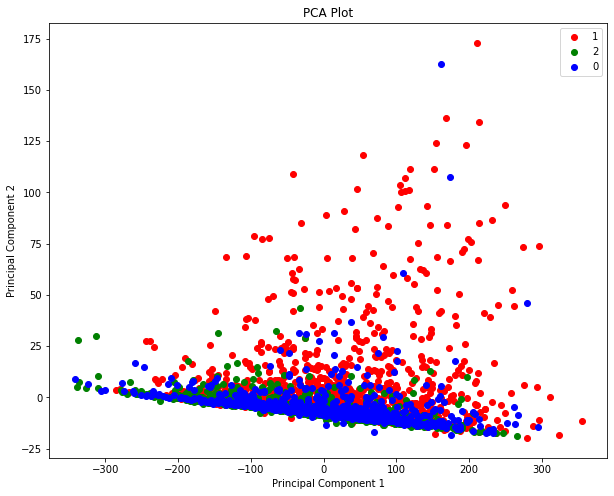

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming your DataFrame is called 'df'
# Extract the features and target
features = fdf.drop('target', axis=1).values
target = fdf['target'].values

# Perform PCA
pca = PCA(n_components=2)  # Set the desired number of components (2 in this case)
components = pca.fit_transform(features)

# Create a new DataFrame with the principal components and the target
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
pca_df['target'] = target

# Plot the results
plt.figure(figsize=(10, 8))
targets = pd.unique(target)  # Get unique target values
colors = ['r', 'g', 'b']  # Set colors for each target (you can customize this as needed)

for target, color in zip(targets, colors):
    indices = pca_df['target'] == target
    plt.scatter(pca_df.loc[indices, 'PC1'], pca_df.loc[indices, 'PC2'], c=color, label=target)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA Plot')
plt.show()


In [9]:
def plot_evaluation_graphs(column_name, target):

    plt.figure(figsize=(10, 5))
    sns.boxplot(x=target, y=column_name, data=df, palette='Set2')
    plt.title('Relationship between {} and Target'.format(column_name))
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df, x=column_name, hue=target, fill=True, palette = 'Set2')
    plt.title('Distribution of {} for each class'.format(column_name))
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.violinplot(x=target, y=column_name, data=df, palette='Set2')
    plt.title('Correlation between {} and Target'.format(column_name))
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=column_name, y=target, data=df, palette='Set2', hue="target", alpha=0.7)
    plt.title('Relationship between {} and Target (Scatter Plot)'.format(column_name))
    plt.show()

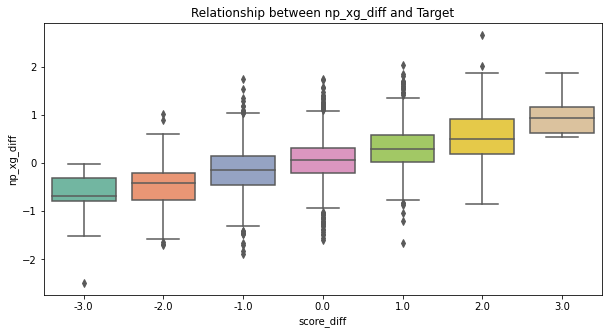

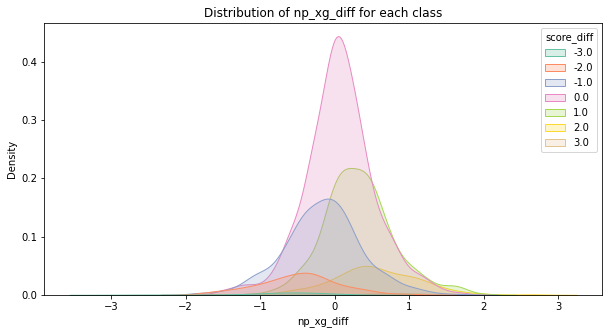

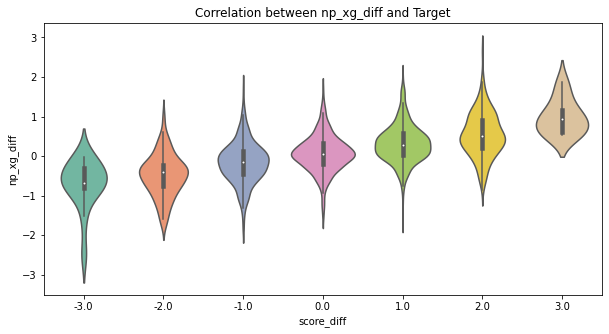

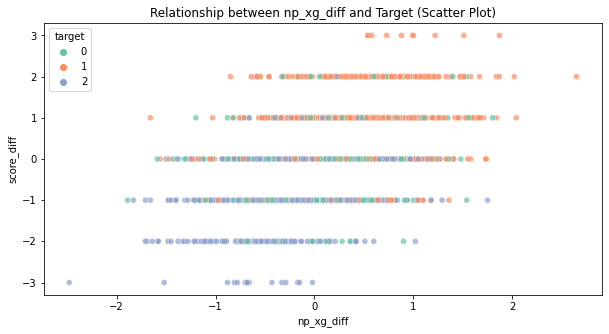

In [12]:
plot_evaluation_graphs('np_xg_diff', 'score_diff')

# Bankroll Kelly

In [35]:
y_test

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

Epoch 1/10
58/58 [==============================] - 0s 5ms/step - loss: 1.0094 - accuracy: 0.4948 - val_loss: 0.8962 - val_accuracy: 0.5886
Epoch 2/10
58/58 [==============================] - 0s 3ms/step - loss: 0.8647 - accuracy: 0.5979 - val_loss: 0.8921 - val_accuracy: 0.5696
Epoch 3/10
58/58 [==============================] - 0s 3ms/step - loss: 0.7828 - accuracy: 0.6500 - val_loss: 0.8969 - val_accuracy: 0.5886
Epoch 4/10
58/58 [==============================] - 0s 3ms/step - loss: 0.7211 - accuracy: 0.6777 - val_loss: 0.8962 - val_accuracy: 0.5835
Epoch 5/10
58/58 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.7233 - val_loss: 0.9268 - val_accuracy: 0.5785
Epoch 6/10
58/58 [==============================] - 0s 3ms/step - loss: 0.6026 - accuracy: 0.7558 - val_loss: 0.9777 - val_accuracy: 0.5544
Epoch 7/10
58/58 [==============================] - 0s 3ms/step - loss: 0.5346 - accuracy: 0.7922 - val_loss: 1.0364 - val_accuracy: 0.5418
Epoch 8/10
58/58 [==

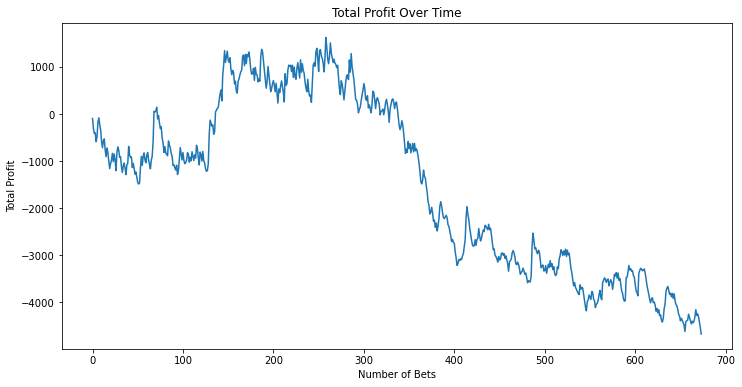

In [72]:
feature_cols = [col for col in df.columns if col != 'target']
X = df[feature_cols]
y = df['target']

X_train_df, X_test_df, y_train_series, y_test_series = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)

encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train_series.values.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test_series.values.reshape(-1, 1)).toarray()

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

def predict_percentages(model, X):
    pred = model.predict(X)
    return pred / 1

predictions = predict_percentages(model, X_test)

profits = []
total_profit = 0
bets_odds = []
bets_count = 0
actual_outcomes = np.argmax(y_test, axis=1)
alpha = np.array([0.057, 0.034, 0.037])
# alpha = np.array([0.,0.,0.])

bankroll = 10000
kelly_fraction = 0.025
outcomes = ["draw    ", "home win", "away win"]

bets_won = []
bets_lost = []

odds_won = []
odds_lost = []

for i in range(len(X_test_df)):
    idx = X_test_df.index[i]
    odds = df.loc[idx, ['mean_0', 'mean_1', 'mean_2']].values
    pred_probs = predictions[i]
    implied_probs = 1 / odds

    diffs = pred_probs - implied_probs
    j = np.argmax(diffs)

    if diffs[j] > alpha[j]:  # if the largest difference is greater than alpha
        bet_fraction = kelly_fraction * (pred_probs[j] * odds[j] - (1 - pred_probs[j])) / (odds[j])
        bet_amount = bet_fraction * bankroll
        bets_odds.append(odds[j])
        bets_count += 1
        actual_outcome = actual_outcomes[i]

        if actual_outcome == j:
            profit = (odds[j] - 1) * bet_amount
            bankroll += profit
            bets_won.append(bet_amount)
            odds_won.append(odds[j])
#             print(f"W {bankroll:.1f} - SD: {df.loc[idx, ['score_diff']][0]}\f - game: {i+1}\f outcome: {outcomes[actual_outcome]}\f - bet: {outcomes[j]}\f - pred prob: {pred_probs[j]:.3f}\f - given prob: {implied_probs[j]:.3f}\f - odds {odds[j]:.3f}\f - bet size: {bet_amount:.3f}\f - profit/loss: {profit:.3f}")
        else:
            profit = -bet_amount
            bankroll += profit
            bets_lost.append(bet_amount)
            odds_lost.append(odds[j])
#             print(f"L {bankroll:.1f} - SD: {df.loc[idx, ['score_diff']][0]}\f - game: {i+1}\f outcome: {outcomes[actual_outcome]}\f - bet: {outcomes[j]}\f - pred prob: {pred_probs[j]:.3f}\f - given prob: {implied_probs[j]:.3f}\f - odds {odds[j]:.3f}\f - bet size: {bet_amount:.3f}\f - profit/loss: {profit:.3f}")

        profits.append(profit)
        total_profit += profit

num_wins = len(bets_won)
win_rate = num_wins / bets_count if bets_count > 0 else 0

print('Total profit:', total_profit)
print('Average bet odds:', np.mean(bets_odds))
print('Number of bets placed:', bets_count)
print('Number of bets won:', num_wins)
print('Win rate:', f'{win_rate*100:.2f}%')
print('Average bet size when won:', np.mean(bets_won))
print('Average bet size when lost:', np.mean(bets_lost))
print('Average odds when won:', np.mean(odds_won))
print('Average odds when lost:', np.mean(odds_lost))


plt.figure(figsize=(12,6))
plt.plot(np.cumsum(profits))
plt.title('Total Profit Over Time')
plt.xlabel('Number of Bets')
plt.ylabel('Total Profit')
plt.show()

In [167]:
indices = [i for i, x in enumerate(X.columns) if x in ['mean_0','mean_1', 'mean_2']]

In [169]:
indices

[64, 65, 66]

In [170]:
def profit_score(estimator, X, y, mean_index = indices, original_data = df, alpha=np.array([0.057, 0.034, 0.037]), bankroll=10000, kelly_fraction=0.025):

    total_profit = 0
    actual_outcomes = y.to_numpy()  # convert pandas series to numpy array

    y_pred_proba = estimator.predict_proba(X)
    for i in range(len(X)):
        features = X[i]
        odds = np.array([features[mean_index[0]], mean_index[indices[1]], mean_index[indices[2]]])
        pred_probs = y_pred_proba[i]
        implied_probs = 1 / odds
        diffs = pred_probs - implied_probs
        j = np.argmax(diffs)

        if diffs[j] > alpha[j]:  
            bet_fraction = kelly_fraction * (pred_probs[j] * odds[j] - (1 - pred_probs[j])) / (odds[j])
            bet_amount = bet_fraction * bankroll

            if actual_outcomes[i] == j:
                total_profit += (odds[j] - 1) * bet_amount
            else:
                total_profit -= bet_amount

    return total_profit

In [171]:
clf = LogisticRegression(C=10, penalty='l1', solver='liblinear')
feature_cols = [col for col in df.columns if col != 'target']
X = df[feature_cols]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf.fit(X_train, y_train)

score = profit_score(clf, X_test, y_test, original_data=df)
print('Profit Score:', score)

KeyError: 0

In [161]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'] # 'liblinear' solver supports both 'l1' and 'l2'
}

# Create a GridSearchCV object
grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    scoring=profit_score,
    refit = 'accuracy', cv=5
)

# Prepare the feature and target variables
feature_cols = [col for col in df.columns if col != 'target']
X = df[feature_cols]
y = df['target']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fitting the model
grid.fit(X_scaled, y)

# Print best parameters and scores
print("Best parameters: ", grid.best_params_)
print("Best Profit score: ", grid.best_score_)

Best parameters:  {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Best Profit score:  -1284754.9107744177


KeyError: 'mean_test_accuracy'

In [41]:

def select_features(X, y, original_data, model, alpha=np.array([0.057, 0.034, 0.037]), bankroll=10000, kelly_fraction=0.025):
    feature_sets = {}

    # RFE
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2),
                  scoring=profit_score,
                  min_features_to_select=1)
    rfecv.fit(X, y)

    selected_features_rfe = [f for f, s in zip(X.columns, rfecv.support_) if s]
    feature_sets['rfe'] = {'features': selected_features_rfe, 'score': rfecv.grid_scores_[-1]}

    # 2. Mutual Information
    mi_selector = SelectKBest(score_func=mutual_info_classif, k=10)
    mi_selector.fit(X, y)

    selected_features_mi = [f for f, s in zip(X.columns, mi_selector.get_support()) if s]
    feature_sets['mutual_info'] = {'features': selected_features_mi, 'score': mi_selector.scores_}

    # 3. Correlation
    corr_matrix = X.corr().abs()
    high_corr_vars = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.75)]
    
    # Select the features which have high correlation
    selected_features_corr = high_corr_vars
    feature_sets['correlation'] = {'features': selected_features_corr, 'score': np.mean([corr_matrix.loc[f, f] for f in high_corr_vars])}

    return feature_sets


In [38]:
def optimize_model(X, y, original_data, models, feature_sets, hyperparameters, alpha=np.array([0.057, 0.034, 0.037]), bankroll=10000, kelly_fraction=0.025):
    best_profit = float('-inf')
    best_model = None
    best_features = None
    best_hyperparameters = None

    for model in models:
        for features in feature_sets:
            X_subset = X[features]
            original_data_subset = original_data[features]

            for hyperparams in hyperparameters:
                # train the model with these hyperparameters
                model.set_params(**hyperparams)
                model.fit(X_subset, y)

                # calculate the profit
                profit = profit_score(model, X_subset, y, original_data_subset, alpha, bankroll, kelly_fraction)

                # if this model/feature set/hyperparameters is the best so far, save it
                if profit > best_profit:
                    best_profit = profit
                    best_model = model
                    best_features = features
                    best_hyperparameters = hyperparams

    return best_model, best_features, best_hyperparameters, best_profit
